# Historische Simulation versus Varianz-Kovarianz-Methode
© Thomas Robert Holy 2019
<br>
Version 1.1.5
<br><br>
Visit me on GitHub: https://github.com/trh0ly

## Voraussetzungen:
An dieser Stelle ist bereits alles vorbereitet.
Das Notebook lässt sich bereits vollständig ausführen

### Optional:
Um ein Portfolio mit anderen Aktienkursen zusammenzustellen, können im Home-Verzeichnis .csv-Datein hochgeladen werden. Diese müssen die folgenden Kriterien erfüllen:
<br>
- Sie umfassen alle denselben Zeitraum
<br>
- Es wird ein Punkt zur Dezimaltrennung verwendet
<br>
- Es wird ein Komma zur Spaltentrennung verwendet
<br>
Abrufbar sind die Daten z.B. auf Yahoo Finance: https://de.finance.yahoo.com/

## Grundlegende Einstellungen:
Zunächst müssen die notwendigen Pakete (auch Module) importiert werden, damit auf diese zugegriffen werden kann. 

In [1]:
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import pandas as pd # Programmbibliothek die Hilfsmittel für die Verwaltung von Daten und deren Analyse anbietet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
import matplotlib.patches as mpatches
import operator # Programmbibliothek, welche die Ausgaben übersichtlicher gestaltet
import datetime as dt # Das datetime-Modul stellt Klassen bereit, mit denen Datums- und Uhrzeitangaben auf einfache und komplexe Weise bearbeitet werden können
import sys # Dieses Modul bietet Zugriff auf einige Variablen, die vom Interpreter verwendet oder verwaltet werden, sowie auf Funktionen, die stark mit dem Interpreter interagieren
from scipy import stats # SciPy ist ein Python-basiertes Ökosystem für Open-Source-Software für Mathematik, Naturwissenschaften und Ingenieurwissenschaften
import prinzip

Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Breite des im Folgenden genutzten DataFrames erhöht und die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########################################################################
#-------------------------------------------------------------------------
SCREEN_WIDTH = 100
centered = operator.methodcaller('center', SCREEN_WIDTH)

pd.set_option('display.width', 125)
plt.rcParams["figure.figsize"] = 15,12.5
#-------------------------------------------------------------------------
##########################################################################

## Datensätze einlesen und manipulieren:
Nun werden Datensätze eingelesen.
Die Datensätze werden manuell definiert und anschließend zum Array "dateinamen" hinzufügt.
Standardmäßig werden zwei Datensätze (VOW3.DE, FME.DE) definiert und im Array "dateinamen" gespeichert.
<br><br>
Hinweis: An dieser Stelle können andere/weitere Datensätze eingelesen werden, sofern die entsprechenden Datensätze im Home-Verzeichnis hochgeladen wurden.

In [3]:
##########################################################################
#-------------------------------------------------------------------------
datensatz1 = 'VOW3.DE'
datensatz2 = 'FME.DE'

#--------------------------------------------------------
# Hier können weitere Datensätze definiert werden.

#datensatz3 = ''
#datensatz4 = ''
#datensatz5 = ''

#--------------------------------------------------------
# Diese müssen ggf. noch in diesem Array ergänzt werden.

dateinamen = [datensatz1,datensatz2]
#-------------------------------------------------------------------------
##########################################################################

Jetzt soll aus jedem eingelesen Datensatz der Aktienkurs zum jeweiligen Tag extrahiert werden. 
Diesen Schritt kann man in Python automatisieren, indem zunächst die leere Liste "kurse" anlegt wird und anschließend von jedem sich in der Liste "dateinamen" befindenden Eintrag die jeweiligen Spalten "Date" und "Adj Close" eingelesen werden.
Dabei werden die verschiedenen im Datensatz vorhanden Spalten mit jedem Komma separiert und Punkte werden als Zeichen für die Dezimaltrennung interpretiert. Anschließend werden die so extrahierten Daten zum Array "kurse" hinzugefügt.

In [4]:
kurse = []        

for eintrag in dateinamen:
    kurs = pd.read_csv(str(eintrag) + '.csv',
                sep=',',
                decimal='.',
                usecols=['Date','Adj Close'])
    kurse.append(kurs)

Nun wird das Modul `datetime` genutzt, um die Datumsspalte des jeweiligen Datensatzes bearbeitbar zu machen.
Zudem wird dem Programm mitgeteilt, dass die Einträge der Spalte "Adj Close" numerisch sind und mit ihnen gerechnet werden kann. Kommt es dabei zu Fehlern werden die entsprechende Werte als NaN-Werte behandelt.


In [5]:
for eintrag in kurse:
    eintrag['Date'] = pd.to_datetime(eintrag['Date'])
    eintrag['Adj Close'] = pd.to_numeric(eintrag['Adj Close'], errors='coerce')

## Dataframe erzeugen und Daten zusammentragen:
Anschließend werden die eingelesenen Daten in einem DataFrame zusammengetragen, wofür das Modul `Pandas` verwendet wird.
Ein DataFrame kann ähnlich wie eine Excel-Tabelle verstanden werden.
Dieser Vorgang kann automatisiert werden, damit die einzelnen Spalten nicht manuell hinzufügt werden müssen. 
Zunächst wird dafür der leere DataFrame "kurschart" angelegt. 
Als nächstes wird für jeden Eintrag in dem Array "kurse" zunächst der entsprechende Aktienkurs in den DataFrame überführt und anschließend wird die dazugehörige Rendite berechnet.
Um Aktienkurse und dazugehörige Renditen auseinander halten zu können, werden die Dateinamen aus dem Array "dateinamen" als Tabellenkopf verwendet.

In [6]:
kurschart = pd.DataFrame()
zaehler = 0

for eintrag in kurse:
    x = dateinamen[zaehler]
    kurschart['Aktienkurs ' + str(x)] = eintrag['Adj Close']
    kurschart['Rendite ' + str(x)] = (eintrag['Adj Close'] - eintrag['Adj Close'].shift(periods = 1)) / eintrag['Adj Close'].shift(periods = 1) 
    zaehler += 1

Um die Portfolio-Rendite zu ermitteln, wird jede zweite Spalte des DataFrames "kurschart" ausgewählt (dies sind die jeweiligen Rendite-Spalten) und in einem zweiten DataFrame ("hilfs_dataframe") abgespeichert. 
Anschließend werden die Spalten zeilenweise addiert und durch die Anzahl der Datensätze geteilt, welche sich im Array "dateinamen" befinden. Dies entspricht einer naiven Diversifikation.

In [7]:
hilfs_dataframe = kurschart.iloc[:, 1::2]
hilfs_dataframe['PF-Rendite'] = hilfs_dataframe.sum(axis = 1, skipna = True) / len(dateinamen)

Diese Portfolio-Rendite wird nun dem ursprünglichen DataFrame "kurschart" angefügt. 
Zudem erhält der DataFrame eine Datumsspalte, welche gleichzeitig als Index verwendet wird.

In [8]:
kurschart['Rendite-PF'] = hilfs_dataframe['PF-Rendite']

kurschart['Datum'] = eintrag['Date']
kurschart = kurschart.set_index('Datum')

Nun kann das DataFrame ausgeben werden:

In [9]:
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Der Dataframe mit den Aktienkursen und deren zugehörigen Renditen ergibt sich wie folgt: ') + '|')
print('#' + SCREEN_WIDTH * '-' + '#')
print(kurschart)
print('#' + SCREEN_WIDTH * '-' + '#')
print(kurschart.isnull().sum())
print('#' + SCREEN_WIDTH * '-' + '#')

#----------------------------------------------------------------------------------------------------#
|  [INFO] Der Dataframe mit den Aktienkursen und deren zugehörigen Renditen ergibt sich wie folgt:   |
#----------------------------------------------------------------------------------------------------#
            Aktienkurs VOW3.DE  Rendite VOW3.DE  Aktienkurs FME.DE  Rendite FME.DE  Rendite-PF
Datum                                                                                         
2018-07-11          138.162201              NaN          79.685799             NaN    0.000000
2018-07-12          138.239578         0.000560          81.349548        0.020879    0.010719
2018-07-13          139.303711         0.007698          81.775162        0.005232    0.006465
2018-07-16          138.065460        -0.008889          82.316849        0.006624   -0.001132
2018-07-17          139.381104         0.009529          83.110023        0.009636    0.009582
...                       

## Streudiagramm anzeigen:
Mithilfe eines Streudiagramms kann die gemeinsame Verteilung von zwei Datensätzen bzw. deren Abhängigkeitsstruktur betrachtet werden.
Um ein solches Streudiagramm zu plotten wird zunächst den Datensatz "x" und den Datensatz "y" definiert. 
Anschließend werden die zugehörigen Renditen in einer Liste gespeichert und um NaN-Werte bereinigt.

In [10]:
##########################################################################
#-------------------------------------------------------------------------
# Hier können auch andere Datensätze definiert werden. Wenn vier Datensätze 
# eingelesen wurden, könnten bspw. auch die Datensätze dateinamen[2] und 
# dateinamen[3] betrachtet werden.
# Hinweis: Die Aufzählung startet bei Null.

x = dateinamen[0]
y = dateinamen[1]

#-------------------------------------------------------------------------
##########################################################################

values_datensatz1 = kurschart['Rendite ' + str(x)].values.tolist()
values_datensatz2 = kurschart['Rendite ' + str(y)].values.tolist()

values_datensatz1 = np.array(values_datensatz1)
values_datensatz2 = np.array(values_datensatz2)

values_datensatz1 = values_datensatz1[np.logical_not(np.isnan(values_datensatz1))]
values_datensatz2 = values_datensatz2[np.logical_not(np.isnan(values_datensatz2))]
values_datensatz1 = values_datensatz1[values_datensatz1 != 0.0]
values_datensatz2 = values_datensatz2[values_datensatz2 != 0.0]
min_len = min(len(values_datensatz1), len(values_datensatz2))
values_datensatz1 = values_datensatz1[:min_len]
values_datensatz2 = values_datensatz2[:min_len]

corr = np.ma.corrcoef(values_datensatz1, values_datensatz2)

Nun kann das Streudiagramm für die jeweiligen Aktienkurse geplottet werden:

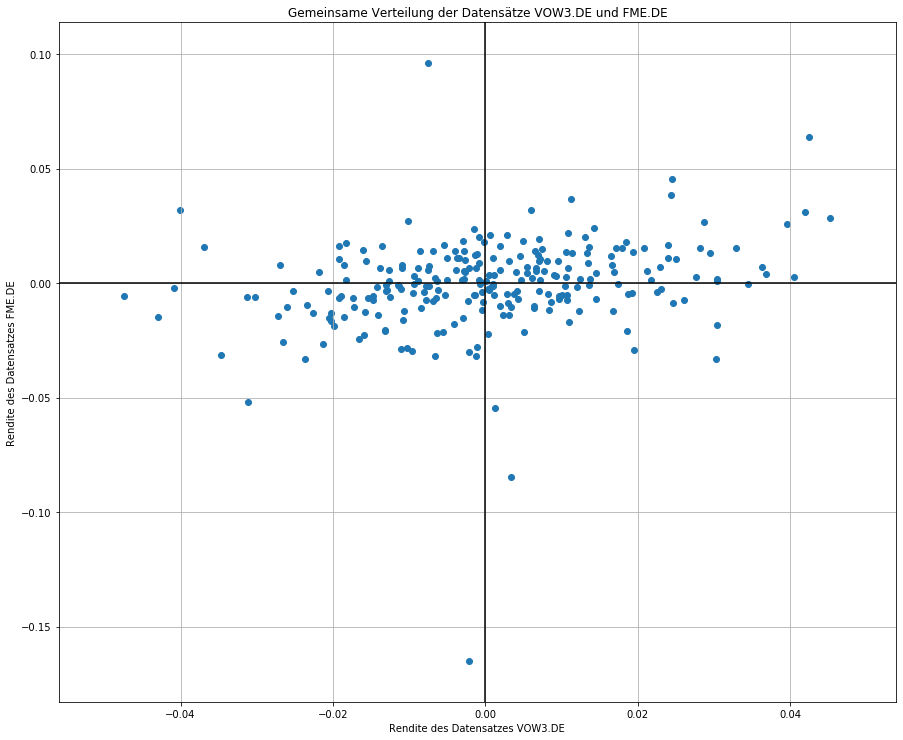

#----------------------------------------------------------------------------------------------------#
|                   [INFO] Der Korrelationskoeffizient beträgt: 0.2529532401634806                   |
#----------------------------------------------------------------------------------------------------#


In [11]:
plt.scatter(values_datensatz1, values_datensatz2)
plt.xlabel('Rendite des Datensatzes ' + str(datensatz1))
plt.ylabel('Rendite des Datensatzes ' + str(datensatz2)) 
plt.title('Gemeinsame Verteilung der Datensätze ' + str(datensatz1) + ' und ' + str(datensatz2))
def easy_plot():
    plt.grid()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.show()
easy_plot()  
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Der Korrelationskoeffizient beträgt: {}'.format(corr[0][1])) + '|')
print('#' + SCREEN_WIDTH * '-' + '#')

Die zugehörigen Erwartungswerte und Standardabweichungen können auch ausgegeben werden. Anschließend wird das Modul `Numpy` genutzt, welches den Erwartungswert und die Standardabweichung berechnet.

In [12]:
mu_datensatz1 = np.mean(values_datensatz1)
mu_datensatz2 =  np.mean(values_datensatz2)

print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Die erwartete Rendite des Datensatzes ' + str(datensatz1) + ' beträgt ' + str(mu_datensatz1) + '.') + '| ')
print('|' + centered('[INFO] Die erwartete Rendite des Datensatzes ' + str(datensatz2) + ' beträgt ' + str(mu_datensatz2) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

std_dattensatz1 = np.std(values_datensatz1)
std_dattensatz2 = np.std(values_datensatz2)

print('|' + centered('[INFO] Der Datensatz ' + str(datensatz1) + ' hat eine Standardabweichung i.H.v. ' + str(std_dattensatz1) + '.') + '| ')
print('|' + centered('[INFO] Der Datensatz ' + str(datensatz2) + ' hat eine Standardabweichung i.H.v. ' + str(std_dattensatz2) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

#----------------------------------------------------------------------------------------------------#
|        [INFO] Die erwartete Rendite des Datensatzes VOW3.DE beträgt 0.0005292171712249241.         | 
|        [INFO] Die erwartete Rendite des Datensatzes FME.DE beträgt -0.00033376251501250566.        | 
#----------------------------------------------------------------------------------------------------#
|       [INFO] Der Datensatz VOW3.DE hat eine Standardabweichung i.H.v. 0.016551642943328664.        | 
|        [INFO] Der Datensatz FME.DE hat eine Standardabweichung i.H.v. 0.020156241318251833.        | 
#----------------------------------------------------------------------------------------------------#


## Portfolio-Renditedaten bereinigen und analysieren:
Da für die Simulationsverfahren fortan die Portfolio-Rendite benötigt wird, wird diese ebenfalls in einer Liste abgespeichert und um NaN-Werte bereinigt. Anschließend wird wiederum der Erwartungswert und die Standardabweichung berechnet.

In [13]:
values_PF = kurschart['Rendite-PF'].values.tolist()
values_PF = np.array(values_PF)
values_PF = values_PF[np.logical_not(np.isnan(values_PF))]
values_PF = values_PF[values_PF != 0.0]

mu_PF = np.mean(values_PF)
std_PF = np.std(values_PF)

print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. ' + str(mu_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Das Porfolio hat eine Standardabweichung i.H.v. ' + str(std_PF) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

#----------------------------------------------------------------------------------------------------#
|         [INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. 0.0001072721245152569.          | 
#----------------------------------------------------------------------------------------------------#
|            [INFO] Das Porfolio hat eine Standardabweichung i.H.v. 0.014593523569872993.            | 
#----------------------------------------------------------------------------------------------------#


Um das Intervall beider Simulationsverfahren zu begrenzen, wird der kleinste und größte Rendite-Wert der in der Liste "values_PF" zu finden ist ermittelt.

In [14]:
mini_values_PF = min(values_PF)
maxi_values_PF = max(values_PF)

## Abfragefunktion definieren:
Nun wird eine Funktion definiert mit deren Hilfe die Feinheit der jeweiligen Verteilungsfunktion bestimmt werden kann.
Standardmäßig wird die höchste Feinheit gewählt, d.h. jede einzelne Realisation wird einzeln erfasst, sodass die Verteilungsfunktion eine sehr hohe Genauigkeit aufweist.
Dies muss jedoch nicht immer sinnvoll sein, weshalb mithilfe einer Abfrage auch andere Werte akzeptiert werden sollen.
Im Grunde die Funktion ob eine Anpassung vorgenommen werden soll oder nicht und wenn ja, welche.

In [15]:
def abfrage():
    abfrage = None
    while abfrage not in ('Ja', 'Nein', 'ja', 'nein', 'j', 'n'):
        abfrage = input('|' + centered('[EINGABE] Möchten Sie die Genauigkeit anpassen? Geben Sie "Ja" oder "Nein" ein: ') + '| ')        
        if abfrage == 'Nein' or abfrage == 'nein' or abfrage == 'n':
            return len(values_PF)
        elif abfrage == 'Ja' or abfrage == 'ja' or abfrage == 'j':
            return int(input('|' + centered('[EINGABE] Geben sie eine Zahl zwischen ' + str(round(len(values_PF)/10)) + ' und ' + str(len(values_PF)) + ' ein') + '| '))    
        else:
            print('|' + centered('[WARNUNG] Geben Sie "Ja" oder "Nein" ein! ') + '| ')

## Verteilungsfunktionen definieren und plotten:
Im letzten Schritt gilt es nun alle Informationen zusammenzutragen und die beiden Verteilungsfunktionen zu zeichnen.

#----------------------------------------------------------------------------------------------------#
|          [EINGABE] Möchten Sie die Genauigkeit anpassen? Geben Sie "Ja" oder "Nein" ein:           | n
#----------------------------------------------------------------------------------------------------#


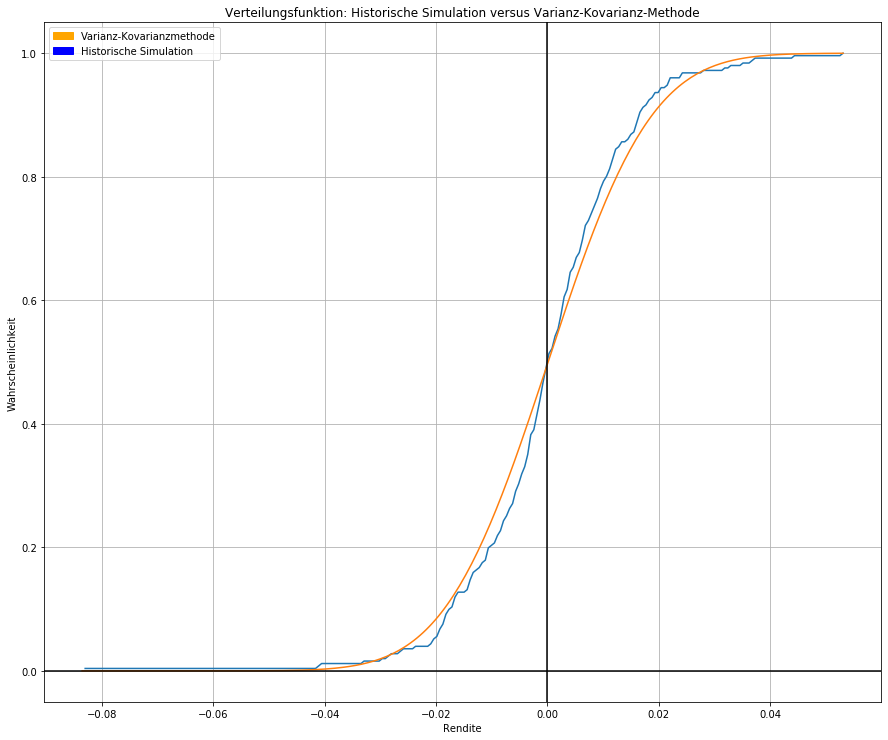

In [16]:
print('#' + SCREEN_WIDTH * '-' + '#')
bins = abfrage()
print('#' + SCREEN_WIDTH * '-' + '#')

#----------------------------------------------------------
# Historische Simulation

H, X1 = np.histogram(values_PF, bins, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H) * dx
plt.plot(X1[1:], F1)

#----------------------------------------------------------
# Varianz-Kovarianz-Methode

array = np.array(np.arange(0.0001, 1, 0.0001))
var_covar_results = stats.norm.ppf(array, mu_PF, std_PF)

var_covar_range = np.linspace(mini_values_PF, maxi_values_PF, bins)
plt.plot(var_covar_range, stats.norm.cdf(var_covar_range, mu_PF, std_PF))

#----------------------------------------------------------
# Restliche Einstellungen für die Grafik

plt.xlabel('Rendite')
plt.ylabel('Wahrscheinlichkeit')
blue_patch = mpatches.Patch(color='blue', label='Historische Simulation')
orange_patch = mpatches.Patch(color='orange', label='Varianz-Kovarianzmethode')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Verteilungsfunktion: Historische Simulation versus Varianz-Kovarianz-Methode')
easy_plot()

## Risikomaße schätzen - Historische Simulation:
### Value at Risk
Um den Value at Risk für die historische Simulation zu bestimmen, werden die Portfolio-Realisationen zunächst der Größe nach sortiert, wobei dieser Schritt gleichzeitig der Ausgangspunkt für die Berechnung des Conditional Value at Risk ist.
Anschließend wird das Alpha-Quantil der Verlustfunktion bestimmt, indem der Parameter "alpha" mit der Länge der Liste "RM_list" multipliziert wird. Der so ermittelte Wert gibt die Position in der Liste "RM_list" an, an welcher sich der Value at Risk zum Konfidenzniveau "alpha" befindet.

In [17]:
def VaR(liste, alpha):
    
    item = (int((alpha * len(RM_list))) - 1)
    VaR = -(RM_list[item])
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der VaR beträgt: ' + str(VaR) + '.') + '| ')

### Conditional Value at Risk
Der Conditional Value at Risk wird grundsätzlich wie der Value at Risk bestimmt, wobei hier jedoch der Mittelwert über alle Realisationen bis zum Alpha-Quantil gebildet wird. 
Daher wird hier nach der Positionsbestimmung die Liste "CVaR_list" mit denjenigen Realisationen aus der Liste "RM_list" gefüllt, welche den Bereich von der kleinsten Realisation bis zum Alpha-Quantil abdecken. 
Die Summe dieser Liste wird anschließend durch die Anzahl ihrer Elemente geteilt.

In [18]:
def CVaR(liste, alpha):
    
    item = int((alpha * len(RM_list)))
    CVaR_list = RM_list[0:item]
    CVaR = -(np.sum(CVaR_list) / len(CVaR_list))
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der CVaR beträgt: ' + str(CVaR) + '.') + '| ')

### Power-Spektrales Risikomaß ($\Phi_b(p)=b \cdot p^{b-1} \text{ mit } p \in \left[0,1\right], ~b \in \left(0,1\right)$)
Für das Power-Spektrale Risikomaß ergibt sich der Erwartungswert aus dem Mittelwert der "RM_list" (der Mittelwert der Portfolio-Realisationen) und das Risiko ergibt sich aus dem Matrixprodukt der transponierten "RM_list" mit der "subj_ws_list", welche subjektive Wahrscheinlichkeiten beinhaltet.
Die Elemente letzterer Liste werden berechnet, indem die Laufvariable jeder Realisation in der geordneten Statisitk "RM_list" (bei "example1" 1 bis 364) durch die Gesamtanzahl der Realisationen (bei "BAS.DE" 253) geteilt und dann mit "gamma" potenziert wird (daher heißt es Power-Spektrales Risikomaß).
Dabei ist bei jeder Berechnung der jeweils vorher errechnete Wert zu subtrahieren.

In [19]:
def power(liste, gamma):    
    
    EW = np.mean(RM_list)
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Power-Spektrales Risikomaß bei der historischen Simulation:') + '| ')
    print('#' + SCREEN_WIDTH * '-' + '#')
    print('|' + centered('Der Erwartungswert beträgt: ' + str(EW) + '.') + '| ')

    subj_ws_list = []
    counter1 = len(RM_list)
    counter2 = len(RM_list) - 1
    for i in RM_list:
        subj_ws = (np.power((counter1 / len(RM_list)), gamma)) - (np.power((counter2 / len(RM_list)), gamma)) 
        counter1 -= 1
        counter2 -= 1
        subj_ws_list.append(subj_ws)
    subj_ws_list = subj_ws_list[::-1]
    risk = (- np.matmul(np.transpose(RM_list), subj_ws_list))
    print('|' + centered('Das Risiko beträgt: ' + str(risk) + '.') + '| ')
    print('#' + SCREEN_WIDTH * '-' + '#')

Prinzip:

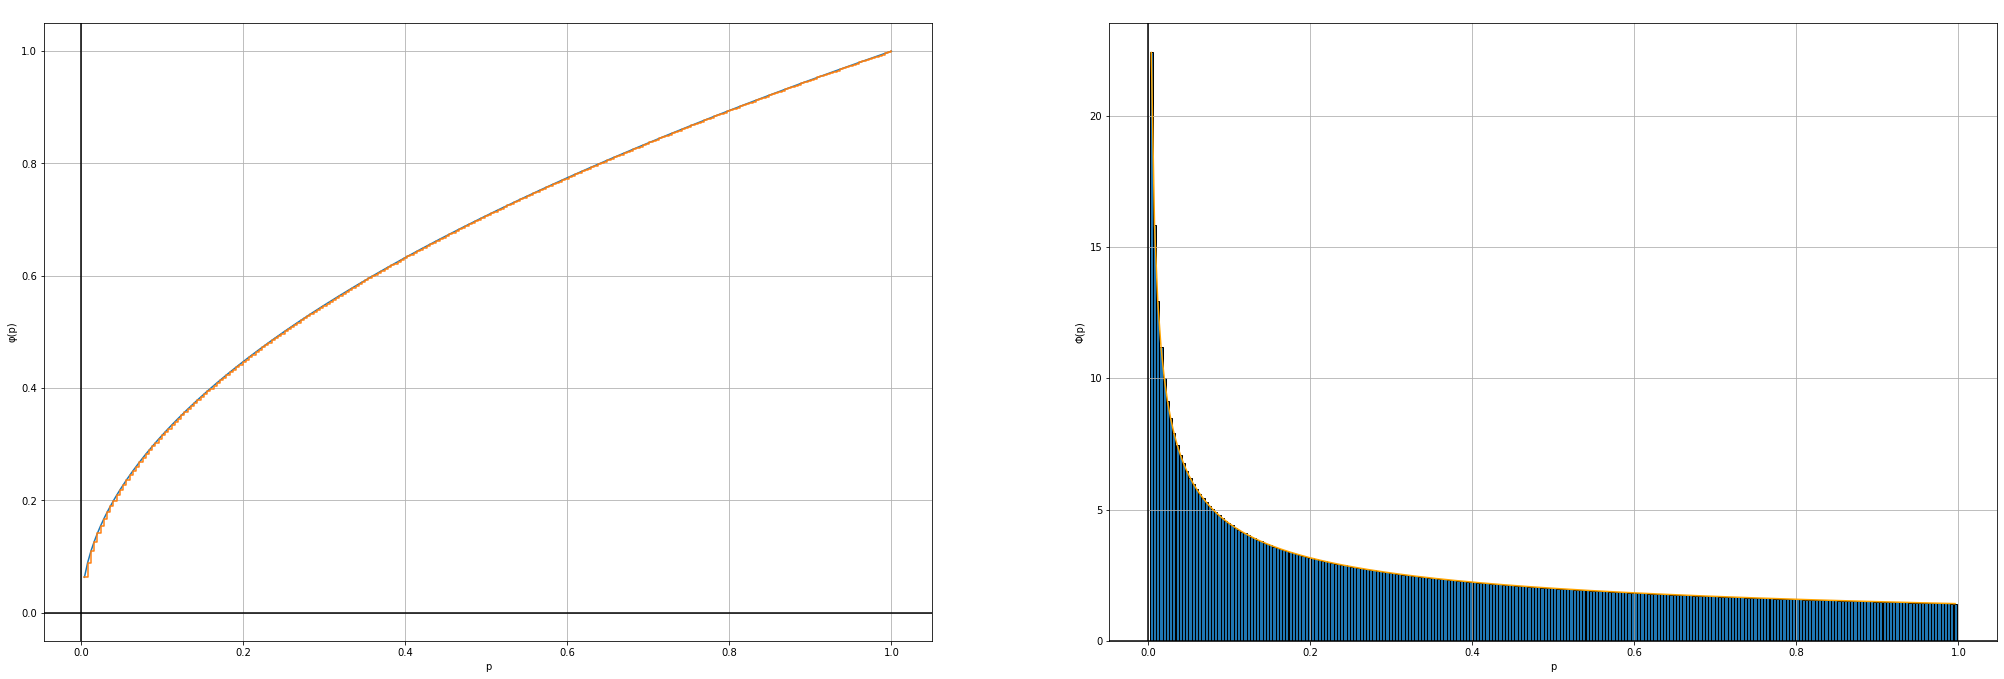

In [20]:
##########################################################################
#-------------------------------------------------------------------------

RM_list = sorted(values_PF)
gamma = 0.5

#-------------------------------------------------------------------------
##########################################################################

prinzip.prinzip(gamma, RM_list)

### Parameterfestlegung und Aufruf der Funktionen

In [21]:
RM_list = sorted(values_PF)

##########################################################################
#-------------------------------------------------------------------------
alpha = 0.1
VaR(RM_list, alpha)

alpha = 0.1
CVaR(RM_list, alpha)

gamma = 0.5
power(RM_list, gamma)
#-------------------------------------------------------------------------
##########################################################################

#----------------------------------------------------------------------------------------------------#
|                               Der VaR beträgt: 0.017789645491228443.                               | 
#----------------------------------------------------------------------------------------------------#
|                              Der CVaR beträgt: 0.026073806207793263.                               | 
#----------------------------------------------------------------------------------------------------#
|                    Power-Spektrales Risikomaß bei der historischen Simulation:                     | 
#----------------------------------------------------------------------------------------------------#
|                        Der Erwartungswert beträgt: 0.00010727212451525667.                         | 
|                             Das Risiko beträgt: 0.012121607385303546.                              | 
#-------------------------------------------------------------------

## Risikomaße schätzen - Varianz-Kovarianz-Methode:
### Value at Risk, Conditional Value at Risk und Power-Spektrales Risikomaß
Die Berechnung des Value at Risk für die Varianz-Kovarianz-Methode ist analog zu der bei der historischen Simulation.
Der einzige Unterschied ist, dass hierbei auf die auf (mu, sigma) parametrisierten Elemente zurückgegriffen wird, welche zuvor als "var_covar_results" bei der Generierung der analytischen Verteilungsfunktion gespeichert wurden.
Für den Conditional Value at Risk und das Power-Spektrale Risikomaß gilt selbiges.
### Parameterfestlegung und Aufruf der Funktionen

In [22]:
RM_list = sorted(var_covar_results)

##########################################################################
#-------------------------------------------------------------------------
alpha = 0.1
VaR(RM_list, alpha)

alpha = 0.1
CVaR(RM_list, alpha)

gamma = 0.5
power(RM_list, gamma)
#-------------------------------------------------------------------------
##########################################################################

#----------------------------------------------------------------------------------------------------#
|                               Der VaR beträgt: 0.018603399368407544.                               | 
#----------------------------------------------------------------------------------------------------#
|                              Der CVaR beträgt: 0.025490031878150177.                               | 
#----------------------------------------------------------------------------------------------------#
|                    Power-Spektrales Risikomaß bei der historischen Simulation:                     | 
#----------------------------------------------------------------------------------------------------#
|                        Der Erwartungswert beträgt: 0.00010727212451525916.                         | 
|                              Das Risiko beträgt: 0.01008497086603982.                              | 
#-------------------------------------------------------------------